In [162]:
import numpy as np
import pandas as pd
import yfinance as yf
import re
import nltk
import matplotlib.pyplot as plt

In [43]:
# read manually labeled data into pandas as a CSV
training_tweets = pd.read_csv('tweets/tweets_labelled_09042020_16072020.csv', sep=';')
# separate any tweets that have not been manually labelled
testing_tweets = training_tweets[training_tweets['sentiment'].isna()]
training_tweets.dropna(subset=['sentiment'], inplace=True)
testing_tweets['created_at'] = pd.to_datetime(testing_tweets['created_at'])
training_tweets['created_at'] = pd.to_datetime(training_tweets['created_at'])

# create a new column within each dataframe that shows the date of each post
testing_tweets['date'] = testing_tweets['created_at'].dt.date
training_tweets['date'] = training_tweets['created_at'].dt.date
training_tweets

/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/1999247077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_tweets['created_at'] = pd.to_datetime(testing_tweets['created_at'])
/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/1999247077.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_tweets['date'] = testing_tweets['created_at'].dt.date


,id,created_at,text,sentiment,date
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,2020-04-15
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,2020-06-25
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,2020-06-04
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,2020-07-03
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,2020-07-09
...,...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive,2020-04-15
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive,2020-07-01
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral,2020-04-29
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,positive,2020-06-19


sentiment
positive    528
neutral     424
negative    348
Name: count, dtype: int64


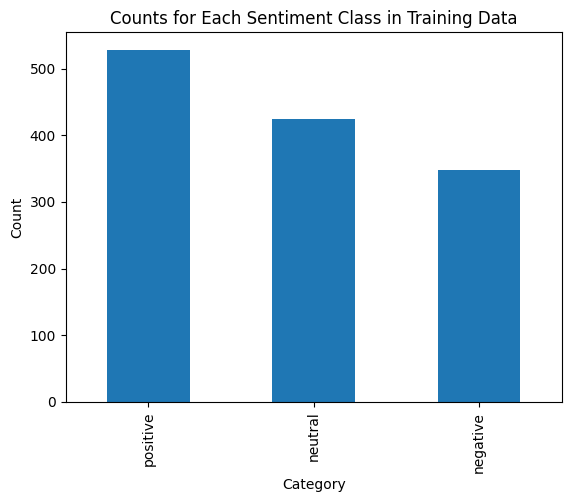

<Figure size 640x480 with 0 Axes>

In [173]:
# create graph for counts of each type of sentiment in the training data
sentiment_counts = training_tweets['sentiment'].value_counts()
print(sentiment_counts)
sentiment_counts.plot(kind='bar')
plt.title('Counts for Each Sentiment Class in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()
plt.savefig('training_sentiment')

In [44]:
testing_tweets

,id,created_at,text,sentiment,date
1300,254563,2020-04-29 01:57:02+00:00,- @investbamboo get $ share on Bamboo then. [ ...,NaN,2020-04-29
1301,280832,2020-05-05 17:58:44+00:00,H&amp;S just formed on 4h chart $spx $spy http...,NaN,2020-05-05
1302,672447,2020-06-26 15:29:14+00:00,@EddyElfenbein what happened to $FB?,NaN,2020-06-26
1303,146759,2020-04-21 11:53:54+00:00,RT @CHItraders: $AAPL expands services busines...,NaN,2020-04-21
1304,116538,2020-04-19 23:34:14+00:00,RT @Lakshmi_888: #SPX $SPX #ES_F $NQ $RUT #DAX...,NaN,2020-04-19
...,...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN,2020-06-04
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN,2020-04-14
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN,2020-06-23
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN,2020-07-14


In [46]:
# gather preliminary information about VOO from Yahoo Finance API
voo = yf.Ticker("VOO")
voo.info

{'phone': '800-523-1036',
 'longBusinessSummary': "The fund employs an indexing investment approach designed to track the performance of the Standard & Poor's 500 Index, a widely recognized benchmark of U.S. stock market performance that is dominated by the stocks of large U.S. companies. The advisor attempts to replicate the target index by investing all, or substantially all, of its assets in the stocks that make up the index, holding each stock in approximately the same proportion as its weighting in the index.",
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 478.15,
 'open': 479.69,
 'dayLow': 477.59,
 'dayHigh': 480.39,
 'regularMarketPreviousClose': 478.15,
 'regularMarketOpen': 479.69,
 'regularMarketDayLow': 477.59,
 'regularMarketDayHigh': 480.39,
 'trailingPE': 26.08007,
 'volume': 3347159,
 'regularMarketVolume': 3347159,
 'averageVolume': 5352241,
 'averageVolume10days': 4057110,
 'averageDailyVolume10Day': 4057110,
 'bid': 477.58,
 'ask': 478.52,
 'bidSize': 1000,
 '

In [47]:
# get the range of dates from which the training data was collected
training_min = training_tweets['date'].min()
training_max = training_tweets['date'].max()

print('TRAINING RANGE:\n')
print('first tweet date: ', training_min)
print('\nlast tweet date: ', training_max)

TRAINING RANGE:

first tweet date:  2020-04-09

last tweet date:  2020-07-16


In [48]:
# downloading VOO ticker data from Yahoo finance API
voo_data = yf.download("VOO", start="2020-04-08", end="2020-07-18")
voo_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-08,246.240005,253.050003,244.050003,251.929993,236.513519,6958600
2020-04-09,255.119995,258.390015,253.139999,255.669998,240.024704,8812600
2020-04-13,254.639999,254.949997,249.380005,253.190002,237.696411,7666400
2020-04-14,258.239990,261.630005,257.209991,260.920013,244.953400,6631100
2020-04-15,255.080002,256.899994,253.110001,255.240005,239.620987,4888900
...,...,...,...,...,...,...
2020-07-13,294.100006,296.450012,288.609985,289.160004,272.876373,3657900
2020-07-14,287.790009,293.320007,286.630005,293.029999,276.528534,4053100
2020-07-15,296.190002,296.750000,293.350006,295.630005,278.982086,6601400


In [49]:
# find missing dates (market closed) and perform interpolation to fill in missing values
date_range = pd.date_range(start=voo_data.index.min(), end=voo_data.index.max())
missing_dates = date_range[~date_range.isin(voo_data.index)]
missing_dates

DatetimeIndex(['2020-04-10', '2020-04-11', '2020-04-12', '2020-04-18',
               '2020-04-19', '2020-04-25', '2020-04-26', '2020-05-02',
               '2020-05-03', '2020-05-09', '2020-05-10', '2020-05-16',
               '2020-05-17', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-30', '2020-05-31', '2020-06-06', '2020-06-07',
               '2020-06-13', '2020-06-14', '2020-06-20', '2020-06-21',
               '2020-06-27', '2020-06-28', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-11', '2020-07-12'],
              dtype='datetime64[ns]', freq=None)

In [50]:
voo_data = voo_data.reindex(date_range)
voo_data = voo_data.interpolate(method='linear')
voo_data

,Open,High,Low,Close,Adj Close,Volume
2020-04-08,246.240005,253.050003,244.050003,251.929993,236.513519,6958600.0
2020-04-09,255.119995,258.390015,253.139999,255.669998,240.024704,8812600.0
2020-04-10,254.999996,257.530010,252.200001,255.049999,239.442631,8526050.0
2020-04-11,254.879997,256.670006,251.260002,254.430000,238.860558,8239500.0
2020-04-12,254.759998,255.810001,250.320004,253.810001,238.278484,7952950.0
...,...,...,...,...,...,...
2020-07-13,294.100006,296.450012,288.609985,289.160004,272.876373,3657900.0
2020-07-14,287.790009,293.320007,286.630005,293.029999,276.528534,4053100.0
2020-07-15,296.190002,296.750000,293.350006,295.630005,278.982086,6601400.0
2020-07-16,293.799988,295.109985,293.149994,294.769989,278.170502,3082900.0


In [51]:

# create a column indicating whether or not the price increased from the previous day
voo_data['price diff'] = voo_data['Close'].diff()
voo_data['Increase'] = (voo_data['price diff'] > 0).astype(int)
voo_data.drop(columns=['price diff'], inplace=True)

voo_data

,Open,High,Low,Close,Adj Close,Volume,Increase
2020-04-08,246.240005,253.050003,244.050003,251.929993,236.513519,6958600.0,0
2020-04-09,255.119995,258.390015,253.139999,255.669998,240.024704,8812600.0,1
2020-04-10,254.999996,257.530010,252.200001,255.049999,239.442631,8526050.0,0
2020-04-11,254.879997,256.670006,251.260002,254.430000,238.860558,8239500.0,0
2020-04-12,254.759998,255.810001,250.320004,253.810001,238.278484,7952950.0,0
...,...,...,...,...,...,...,...
2020-07-13,294.100006,296.450012,288.609985,289.160004,272.876373,3657900.0,0
2020-07-14,287.790009,293.320007,286.630005,293.029999,276.528534,4053100.0,1
2020-07-15,296.190002,296.750000,293.350006,295.630005,278.982086,6601400.0,1
2020-07-16,293.799988,295.109985,293.149994,294.769989,278.170502,3082900.0,0


In [52]:
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
# function for tokenizing and preprocessing the given tweets
def preprocess_tweets(df_tweet, is_label):
    stop_words = set(stopwords.words('english'))

    cleantweet=[]

    # define regex pattern to match emojis to remove them when cleaning.
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  
                                u"\U0001F300-\U0001F5FF"  
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F1E0-\U0001F1FF"  
                                u"\U00002500-\U00002BEF"  
                                u"\U00002702-\U000027B0"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # dingbats
                                u"\u3030"
                                "]+", flags=re.UNICODE)

    for i in range(len(df_tweet)):
        # for each tweet, replace any newline characters, periods, or commas with white space.
        if is_label:
            tweet = df_tweet.iloc[i]['text']
        else:
            tweet = df_tweet.iloc[i]['full_text']
        tweet=tweet.replace('\r',' ')
        tweet=tweet.replace('\n',' ')
        tweet=tweet.replace('. ',' ')
        tweet=tweet.replace(', ',' ')

        tweet = emoji_pattern.sub(r'', tweet)

        # creates an array of tokens split based on white space
        tokens = tweet.split(' ')
        tweet_hashtags=[]
        # keep track of the tokens in the tweet
        tweet_token=[]
        for t in tokens:
            # for each token, add it to the list of tokens in the tweet if it isn't a link
            if t not in stop_words and "https:" not in t and not t.startswith("#") and not t.startswith('$') and not t.startswith('@'):
                t = re.sub(r'[^\w\s]', '', t)
                tweet_token.append(t)
            # append word attached to hashtag to the list of tokens
            elif t.startswith('#') or t.startswith('$'):
                hashtag_content = t[1:].split()
                tweet_token.extend(hashtag_content)
            elif t.startswith('@'):
                tweet_token.append('[USER]')
            elif t.startswith("https:"):
                tweet_token.append('[URL]')

        # add the list of tweet tokens to the list of clean tweets
        cleantweet.append(" ".join(tweet_token).lower())

    # add the array of clean tweets to the dataframe as a new column
    df_tweet['clean tweet']= cleantweet
    return df_tweet

In [54]:
training_tweets = preprocess_tweets(training_tweets, True)
training_tweets

,id,created_at,text,sentiment,date,clean tweet
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,2020-04-15,rt [user] yo enter win 1000 monarch tokens us...
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,2020-06-25,srilanka surcharge fuel removed the surcharge...
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,2020-06-04,net issuance increases fund fiscal programs gt...
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,2020-07-03,rt [user] how much amazons traffic served fast...
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,2020-07-09,amd ryzen 4000 desktop cpus looking great trac...
...,...,...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive,2020-04-15,stocks back recovery room [url] fair value 5...
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive,2020-07-01,rt [user] breadth expanding last weeks discus...
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral,2020-04-29,rt [user] rompasrajapalot a big new camp rajap...
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,positive,2020-06-19,aapl qqq top may [url]


In [55]:
tweet_date_range = pd.date_range(start=training_tweets['date'].min(), end=training_tweets['date'].max())
missing_dates = tweet_date_range[~tweet_date_range.isin(training_tweets['date'])]
missing_dates


/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/3499014754.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  missing_dates = tweet_date_range[~tweet_date_range.isin(training_tweets['date'])]


DatetimeIndex(['2020-04-30', '2020-05-01', '2020-05-02', '2020-05-10',
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-06-12'],
              dtype='datetime64[ns]', freq=None)

**Vectorization using Word2Vec**

In [56]:
from gensim.models import Word2Vec

In [57]:
# testing performance of word2Vec representation
word2vec_model = Word2Vec(sentences=training_tweets['clean tweet'], vector_size = 100)

# function for calculating the vector representation of each word in the tweet
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0
    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [58]:

X_word2vec = [average_word_vectors(tweet, word2vec_model, word2vec_model.wv.index_to_key, 100) for tweet in training_tweets['clean tweet']]
training_tweets['word2vec'] = X_word2vec

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [60]:
# splitting the pre-labeled tweets into training and testing sets for sentiment classification model
ordered_labels = ['negative', 'neutral', 'positive']
label_encoder = LabelEncoder()

label_encoder.fit(ordered_labels)
Y_encoded = label_encoder.transform(training_tweets['sentiment'])

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X_word2vec, Y_encoded, test_size = 0.15, random_state=1680)

In [62]:
# fit random forest classifier to preprocessed training data with word2vec representation
rf_classifier = RandomForestClassifier(n_estimators = 300, random_state=1680)
rf_classifier.fit(X_train, Y_train)

Y_pred = rf_classifier.predict(X_test)

In [63]:
accuracy_score(Y_test, Y_pred)

0.40512820512820513

**TF-IDF Vectorizer w/Random Forest**

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(training_tweets['clean tweet'], Y_encoded, test_size=0.1, random_state=1680)

In [66]:
# fit tf-idf vectorizer to data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [69]:
# use random forest to classify tweets embedded using tf-idf
rf_tfidf = RandomForestClassifier(n_estimators = 300, random_state=1680)
rf_tfidf.fit(X_train_tfidf, Y_train)

# compare accuracy score w/word2vec
rf_tfidf_pred = rf_tfidf.predict(X_test_tfidf)
accuracy_score(Y_test, rf_tfidf_pred)

0.5307692307692308

**Examine Correlation w/ Stock Price Movement**

need to test this first with the labelled tweets, then with the non-labelled tweets.

In [73]:
# gather coefficients from random forest and tf-idf model.
feature_importances = rf_tfidf.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# create and sort a dictionary of words to coefficients to see which words are the most important
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [74]:
print("top words associated with positive sentiment")
for word, importance in sorted_features[:20]:
    print(f"{word}, {importance}")

top words associated with positive sentiment
url, 0.022511252296561705
user, 0.01421134287244884
rt, 0.011436128010299218
spx, 0.008896475592445307
stocks, 0.008331416562947475
buy, 0.008021212116032357
spy, 0.007419324029772262
fb, 0.007225979661806201
stockmarket, 0.005756731179640792
good, 0.0056562326636115995
amzn, 0.005468472522150838
aapl, 0.005361735583466667
short, 0.005181607589659274
bullish, 0.0050470571661261725
investing, 0.0049622100913102474
market, 0.0045825678860087265
nice, 0.004418129360758617
trading, 0.004315716075080597
es_f, 0.003627598682962044
great, 0.003603342419112092


In [75]:
# associated with either negative sentiment or none at all
print("top words associated with negative sentiment")
for word, importance in sorted_features[-20:]:
    print(f"{word}, {importance}")

top words associated with negative sentiment
pointing, 0.0
police, 0.0
population, 0.0
prcp, 0.0
predict, 0.0
prospect, 0.0
regime, 0.0
roa, 0.0
rub, 0.0
sblk, 0.0
shoutout, 0.0
sony, 0.0
stayathome, 0.0
tgodf, 0.0
thesis, 0.0
uaa, 0.0
underway, 0.0
uptick, 0.0
web, 0.0
ylds, 0.0


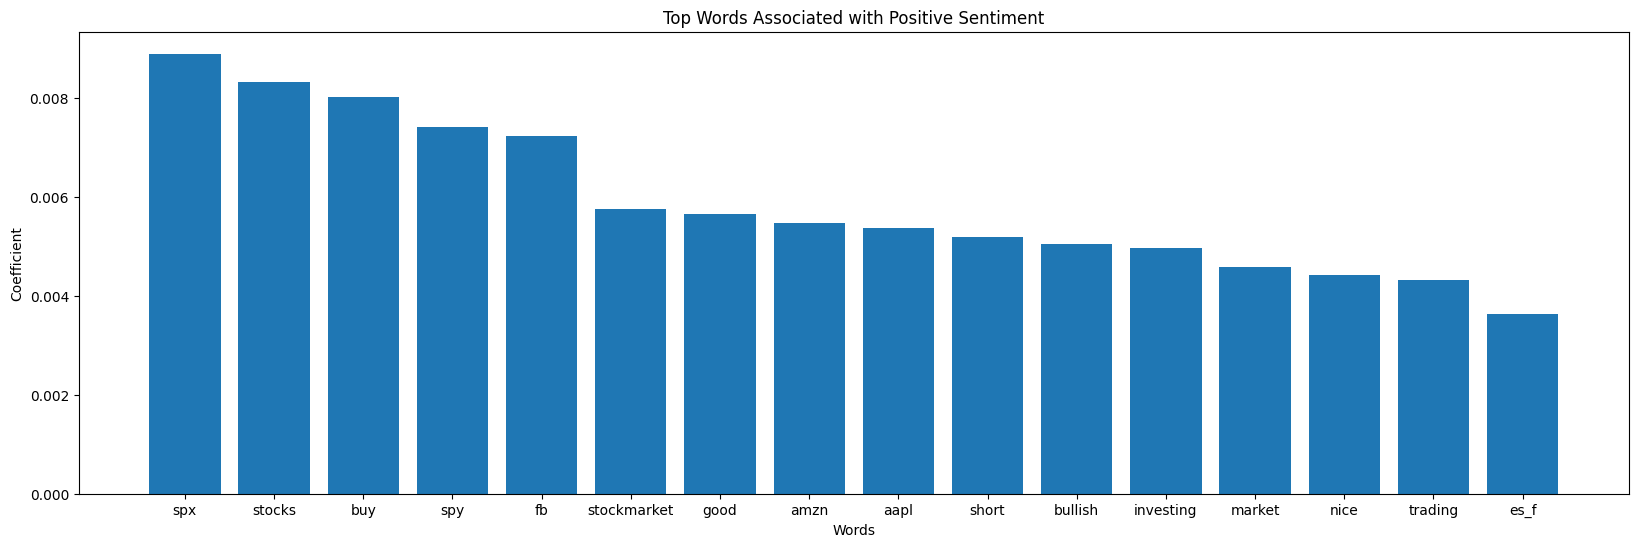

In [169]:
# graph representation of feature importance analysis
to_graph = sorted_features[3:19]
labels = [item[0] for item in to_graph]
coefs = [item[1] for item in to_graph]

plt.figure(figsize=(20, 6))
plt.bar(labels, coefs)
plt.xlabel('Words')
plt.ylabel('Coefficient')
plt.title('Top Words Associated with Positive Sentiment')
plt.savefig('feat_importance')

In [160]:
def get_top_words(clf, tf_idf): 
    feature_importances = clf.feature_importances_
    feature_names = tf_idf.get_feature_names_out()

    feature_importance_dict = dict(zip(feature_names, feature_importances))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    print("top words associated with positive sentiment")
    for word, importance in sorted_features[:15]:
        print(f"{word}, {importance}")

    print("top words associated with negative sentiment")
    for word, importance in sorted_features[-15:]:
        print(f"{word}, {importance}")

repeat w/testing set

In [95]:
# preprocess
testing_tweets = preprocess_tweets(testing_tweets, True)
# tf-idf vectorization
test_vec = tfidf_vectorizer.transform(testing_tweets['clean tweet'])
# predictions
test_vec_pred = rf_tfidf.predict(test_vec)

testing_tweets['predicted sentiment'] = test_vec_pred
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
testing_tweets['predicted sentiment'] = testing_tweets['predicted sentiment'].map(sentiment_map)
testing_tweets


/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/635369636.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweet['clean tweet']= cleantweet
/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/4152310887.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_tweets['predicted sentiment'] = test_vec_pred
/var/folders/93/79pp4_gj28nf3ddg6t01dgnr0000gn/T/ipykernel_13097/4152310887.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,id,created_at,text,sentiment,date,clean tweet,predicted sentiment
1300,254563,2020-04-29 01:57:02+00:00,- @investbamboo get $ share on Bamboo then. [ ...,NaN,2020-04-29,[user] get share bamboo aapl msft jpm tsla] ...,positive
1301,280832,2020-05-05 17:58:44+00:00,H&amp;S just formed on 4h chart $spx $spy http...,NaN,2020-05-05,hamps formed 4h chart spx spy [url],neutral
1302,672447,2020-06-26 15:29:14+00:00,@EddyElfenbein what happened to $FB?,NaN,2020-06-26,[user] happened fb?,neutral
1303,146759,2020-04-21 11:53:54+00:00,RT @CHItraders: $AAPL expands services busines...,NaN,2020-04-21,rt [user] aapl expands services business marke...,neutral
1304,116538,2020-04-19 23:34:14+00:00,RT @Lakshmi_888: #SPX $SPX #ES_F $NQ $RUT #DAX...,NaN,2020-04-19,rt [user] spx spx es_f nq rut dax ftse es_f qq...,neutral
...,...,...,...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN,2020-06-04,with ad revenues falling whats impact social m...,positive
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN,2020-04-14,rt [user] well another point add dent current ...,positive
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN,2020-06-23,itox working contract fortune 500 aerospace fi...,positive
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN,2020-07-14,dis could break 120 pin 125gt 130 [url] [url],neutral


In [87]:
get_top_words(rf_tfidf, tfidf_vectorizer)

top words associated with positive sentiment
url, 0.022511252296561705
user, 0.01421134287244884
rt, 0.011436128010299218
spx, 0.008896475592445307
stocks, 0.008331416562947475
buy, 0.008021212116032357
spy, 0.007419324029772262
fb, 0.007225979661806201
stockmarket, 0.005756731179640792
good, 0.0056562326636115995
amzn, 0.005468472522150838
aapl, 0.005361735583466667
short, 0.005181607589659274
bullish, 0.0050470571661261725
investing, 0.0049622100913102474
top words associated with negative sentiment
prospect, 0.0
regime, 0.0
roa, 0.0
rub, 0.0
sblk, 0.0
shoutout, 0.0
sony, 0.0
stayathome, 0.0
tgodf, 0.0
thesis, 0.0
uaa, 0.0
underway, 0.0
uptick, 0.0
web, 0.0
ylds, 0.0


In [89]:
# val_tweets from dataset of remaining unlabelled tweets.
val_tweets = pd.read_csv('tweets/tweets_remaining_09042020_16072020.csv', sep=';')

val_tweets['created_at'] = pd.to_datetime(val_tweets['created_at'])

# create a new column within each dataframe that shows the date of each post
val_tweets['date'] = val_tweets['created_at'].dt.date

In [94]:
val_tweets = preprocess_tweets(val_tweets, False)
val_tweets

,id,created_at,full_text,date,clean tweet
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,2020-04-09,[user] little volume with 10t think could spx ...
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,2020-04-09,es_f achieved target 2780 closing 50 fibonacci...
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...,2020-04-09,rt [user] silvergold indicator creates one lar...
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,2020-04-09,[user] hedged msft position close seemed getti...
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,2020-04-09,rt [user] 3 surprisingly controversial stocks ...
...,...,...,...,...,...
923668,938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...,2020-07-16,rt [user] we tend spend lot time big tech name...
923669,938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F,2020-07-16,you spx spy es_f
923670,938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...",2020-07-16,ko cocacola options maxpain chart open interes...
923671,938671,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...,2020-07-16,heres dividends watchlist 01040710 payout cyc...


In [102]:
val_tfidf = tfidf_vectorizer.transform(val_tweets['clean tweet'])
# predictions
val_pred = rf_tfidf.predict(val_tfidf)

val_tweets['sentiment_val'] = val_pred
# originally mapped to 2, 1, and 0
val_tweets['predicted_sentiment'] = val_tweets['sentiment_val'].map(sentiment_map)
# adjust the predictions so that we can calculate an average sentiment score by day.
val_tweets['sentiment_val'] = val_tweets['sentiment_val'] - 1

In [107]:
val_tweets

,id,created_at,full_text,date,clean tweet,sentiment_val,predicted_sentiment
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,2020-04-09,[user] little volume with 10t think could spx ...,-1,negative
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,2020-04-09,es_f achieved target 2780 closing 50 fibonacci...,1,positive
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...,2020-04-09,rt [user] silvergold indicator creates one lar...,1,positive
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,2020-04-09,[user] hedged msft position close seemed getti...,1,positive
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,2020-04-09,rt [user] 3 surprisingly controversial stocks ...,-1,negative
...,...,...,...,...,...,...,...
923668,938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...,2020-07-16,rt [user] we tend spend lot time big tech name...,1,positive
923669,938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F,2020-07-16,you spx spy es_f,0,neutral
923670,938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...",2020-07-16,ko cocacola options maxpain chart open interes...,1,positive
923671,938671,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...,2020-07-16,heres dividends watchlist 01040710 payout cyc...,1,positive


In [155]:
# calculate sentiment score for each day, movement, and log of price. put this into new dataframe
df_sentiment_scores = val_tweets.groupby('date')['sentiment_val'].mean().to_frame(name='sentiment_score')
df_sentiment_scores['Increase'] = voo_data['Increase']
df_sentiment_scores['log_price'] = np.log(voo_data['Close'])
df_sentiment_scores

,sentiment_score,Increase,log_price
date,,,
2020-04-09,0.350262,1,5.543888
2020-04-10,0.370990,0,5.541460
2020-04-11,0.344951,0,5.539026
2020-04-12,0.388943,0,5.536586
2020-04-13,0.428583,0,5.534140
...,...,...,...
2020-07-12,0.475034,0,5.670019
2020-07-13,0.495227,0,5.666980
2020-07-14,0.435476,1,5.680275


In [156]:
from scipy.stats import spearmanr

# rank-biserial correlation: does not assume underlying normal distribution.
correlation, p_value = spearmanr(df_sentiment_scores['sentiment_score'], df_sentiment_scores['log_price'])
print("Rank-Biserial Correlation Coefficient: ", correlation)
print("P-value: ", p_value)

Rank-Biserial Correlation Coefficient:  0.5609916399390082
P-value:  1.1161508799735399e-07


In [157]:
# measures correlation between average sentiment score per day and log of stock price
correlation = df_sentiment_scores['sentiment_score'].corr(df_sentiment_scores['log_price'])
correlation

0.47585690151878024

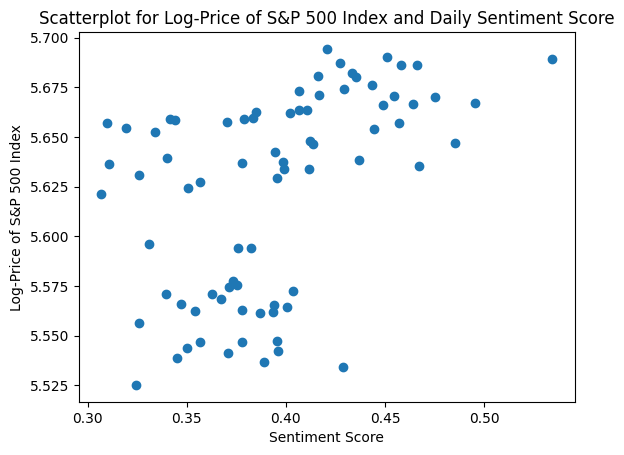

<Figure size 640x480 with 0 Axes>

In [171]:
import matplotlib.pyplot as plt

plt.scatter(df_sentiment_scores['sentiment_score'], df_sentiment_scores['log_price'])
plt.xlabel('Sentiment Score')
plt.ylabel('Log-Price of S&P 500 Index')
plt.title('Scatterplot for Log-Price of S&P 500 Index and Daily Sentiment Score')
plt.show()


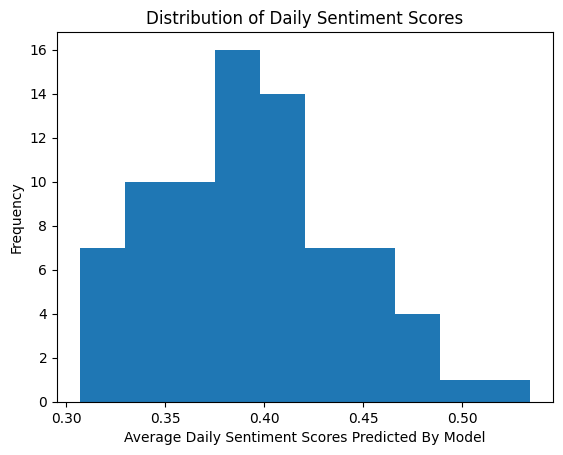

In [172]:
plt.hist(df_sentiment_scores['sentiment_score'])
plt.title('Distribution of Daily Sentiment Scores')
plt.xlabel('Average Daily Sentiment Scores Predicted By Model')
plt.ylabel('Frequency')
plt.savefig('sentiment_distr')